<!-- <div dir = "rtl">
<span style='font-family:Vazirmatn'>

# *تعریف کتابخانه ها*
 ## 1. <span style='color:lightgreen'> سیمپی </span>:
  ## سیمپی یک کتابخانه پایتون است که برای شبیه سازی رخداد های گسسته بکار می رود برای دسترسی به اطلاعات بیشتر لطفا به [سایت](https://simpy.readthedocs.io/en/latest/contents.html) آن مراجعه کنید.


</span>
</div> -->

In [1]:
import simpy
import random
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
random.seed(20)

## Define the methods that we need to generate **service times** and **interarrival** Times

In [3]:
def interArrivalTimeGenerator():
    ARRIVAL_TIMES = [1, 2, 3, 4]
    WEIGHTS = [0.25, 0.40, 0.20, 0.15]
    arrival_time = random.choices(ARRIVAL_TIMES , weights = WEIGHTS, k = 1 )
    return arrival_time[0]

def hubbleTimeGenerator():
    SERVICE_TIMES = [2, 3, 4, 5]
    WEIGHTS = [0.3, 0.28, 0.25, 0.17]
    service_time = random.choices(SERVICE_TIMES , weights = WEIGHTS, k = 1 )
    return service_time[0]

def bakerTimeGenerator():
    SERVICE_TIMES = [3, 4, 5, 6]
    WEIGHTS = [0.35, 0.25, 0.20, 0.20]
    service_time = random.choices(SERVICE_TIMES , weights = WEIGHTS, k = 1 )
    return service_time[0]

## Initial of global variables that we need in plot

In [4]:
hubble_service_times = []
baker_service_times = []
presence_times = []
wait_times = []
total_utilization_time = 0
last_check_time = 0
congestion = []
total_server_count = [0]
server_time = []

## Methods that we need to collect various times 

In [5]:
def recordHubbleServiceTimes(service_time):
    hubble_service_times.append(service_time)
    
def recordBakerServiceTimes(service_time):
    baker_service_times.append(service_time)
    
def getRecordServiceTimes():
    return hubble_service_times, baker_service_times

def recordPresenceTimes(presence_time):
    presence_times.append(presence_time)
    return presence_times

def getRecordPresenceTimes():
    return presence_times

def recordWaitTimes(wait_time):
    wait_times.append(wait_time)
    
def getRecordWaitTimes():
    return wait_times

## A method to calculate the times that *congestion* occurred, and the data we need to plot the **Q(t)** diagram. 

In [6]:
def getCongestionCounter():
    return congestion

In [7]:
def congestionCounter(hubble_queue, baker_queue, hubble_count, baker_count, now, people_count = 0, temp_time = []):
    
    people_count = hubble_queue + baker_queue + hubble_count + baker_count
    if people_count > 5:
        congestion.append(1)
    
    server_count_last_index = len(total_server_count) - 1
    
    if people_count != total_server_count[server_count_last_index]:
        total_server_count.append(people_count)
        temp_time.append(now)
        
        if len(temp_time) >= 2:
            server_time.append(temp_time.copy())
            temp_time.clear()
            temp_time.append(now)

## methods to collect the data we need for plot of **Busy Indicator B(t)**

In [8]:
hubble_working_time = []

def hubbleBusyIndicator(hubble, now, hubble_service_time):
    hubble_time = []
    if hubble > 0:
        hubble_time.append(now)
        hubble_time.append(now + hubble_service_time)
        hubble_working_time.append(hubble_time)
          
baker_working_time = []

def bakerBusyIndicator(baker, now, baker_service_time):
    baker_time = []
    if baker > 0:
        baker_time.append(now)
        baker_time.append(now + baker_service_time)
        baker_working_time.append(baker_time)

# **The Main part of the simulation**

In [9]:
def customer(env, hubble, baker):
    
    arrival_time = env.now
    congestionCounter(len(hubble.queue), len(baker.queue), hubble.count, baker.count, env.now)
    
    
    if len(hubble.queue) == 0 or len(baker.queue) > 0:
        
        with hubble.request() as request:
            yield request
            
            recordWaitTimes(env.now - arrival_time)
            
            hubble_service_time = hubbleTimeGenerator()
            
            hubbleBusyIndicator(hubble.count, env.now, hubble_service_time)
            
            recordHubbleServiceTimes(hubble_service_time)
            
            yield env.timeout(hubble_service_time)
            
    else:
        with baker.request() as request:
            yield request
            
            recordWaitTimes(env.now - arrival_time)
            
            baker_service_time = bakerTimeGenerator()
            
            bakerBusyIndicator(baker.count, env.now, baker_service_time)
            
            recordBakerServiceTimes(baker_service_time)
            
            yield env.timeout(baker_service_time)
    
    recordPresenceTimes(env.now - arrival_time)
            
 
def autoRestaurant(env, hubble, baker):
    global total_utilization_time 
    global last_check_time
    global hubble_working_time
    global baker_working_time
    
    while True:
        yield env.timeout(interArrivalTimeGenerator())
        env.process(customer(env, hubble, baker))
        
        if hubble.count + baker.count > 0:
            total_utilization_time += env.now - last_check_time
        last_check_time = env.now
        
TIME_UNIT = 2250
env = simpy.Environment()
hubble = simpy.Resource(env, capacity = 1)
baker = simpy.Resource(env, capacity = 1)
env.process(autoRestaurant(env, hubble, baker))
env.run(until = TIME_UNIT)

## calculate, record the various times and other stuff

In [10]:
hubble_service_times, baker_service_times = getRecordServiceTimes()
wait_times = getRecordWaitTimes()
presence_times_times = getRecordPresenceTimes()


hubble_customers = len(hubble_service_times)
baker_customers = len(baker_service_times)

total_customers = hubble_customers + baker_customers
total_service_times = hubble_service_times + baker_service_times

# **Q1**: 
## The average wait time and presence time.

In [11]:
average_wait_times = sum(wait_times) / total_customers
average_presence_times = sum(presence_times) / total_customers

print(f"The average wait time is {average_wait_times:.2f}")
print(f"The average presence time is {average_presence_times:.2f}")

The average wait time is 1.89
The average presence time is 5.52


# **Q2**: 
## Coefficient of efficiency of Hubble and Baker and the Whole System.

In [12]:
total_simulation_time = TIME_UNIT
hubble_Utilization = sum(hubble_service_times) / total_simulation_time
baker_Utilization = sum(baker_service_times) / total_simulation_time
system_Utilization = total_utilization_time / total_simulation_time

print(f" The Hubble Utilization coefficient is :{hubble_Utilization:.2f}\n"
    , f"The Baker Utilization coefficient is :{baker_Utilization:.2f}\n"
    , f"The System Utilization coefficient is :{system_Utilization:.2f}"
    )

 The Hubble Utilization coefficient is :0.97
 The Baker Utilization coefficient is :0.68
 The System Utilization coefficient is :0.88


## Method to represent the wait time, presence time and service time

In [13]:
def calculate_value_counts(input):
    value_counts = {value: input.count(value) for value in set(input)}
    values = list(value_counts.keys())
    frequencies = list(value_counts.values())
    return values, frequencies

## The plot for **Q1**:

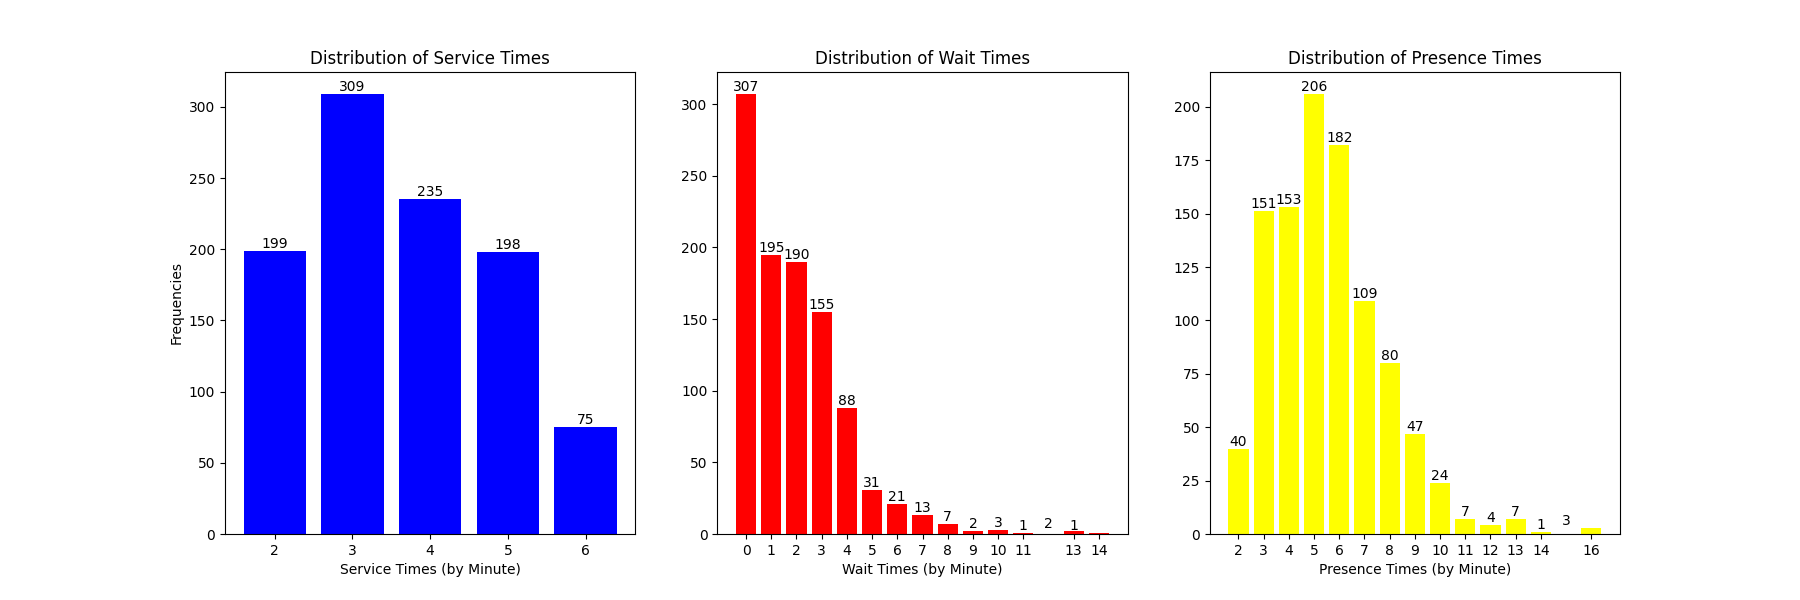

In [14]:

plt.figure(figsize = (18, 6))

values, frequencies = calculate_value_counts(total_service_times)
plt.subplot(131)
plt.title("Distribution of Service Times")
plt.bar(values, frequencies, color = "Blue")

for i, value in enumerate(frequencies):
    plt.text(i + 2, value, str(value), ha = "center", va = "bottom")

plt.xlabel("Service Times (by Minute)")
plt.ylabel("Frequencies")


values, frequencies = calculate_value_counts(wait_times)
plt.subplot(132)
plt.title("Distribution of Wait Times")
plt.bar(values, frequencies, color = "Red")
plt.xticks(values)

for i, value in enumerate(frequencies):
    plt.text(i, value, str(value), ha = "center", va = "bottom")

plt.xlabel("Wait Times (by Minute)")


values, frequencies = calculate_value_counts(presence_times)
plt.subplot(133)
plt.title("Distribution of Presence Times")
plt.bar(values, frequencies, color = "Yellow")
plt.xticks(values)

for i, value in enumerate(frequencies):
    plt.text(i + 2, value, str(value), ha = "center", va = "bottom")
    
plt.xlabel("Presence Times (by Minute)")

plt.show()

# **Q4**:
## If we knew that there is somebody in system, what is the probability that a customer services getting provided by Baker?

In [15]:
print(f"The probability if someone in system, so getting serviced by Baker: {baker_customers / total_customers:.2f}")

The probability if someone in system, so getting serviced by Baker: 0.35


# **Q5**:
## how many percent of customers are serviced by Hubble and Baker.

The 64.76% are customers getting serviced by Hubble.
The 35.24% are customers getting serviced by Baker.


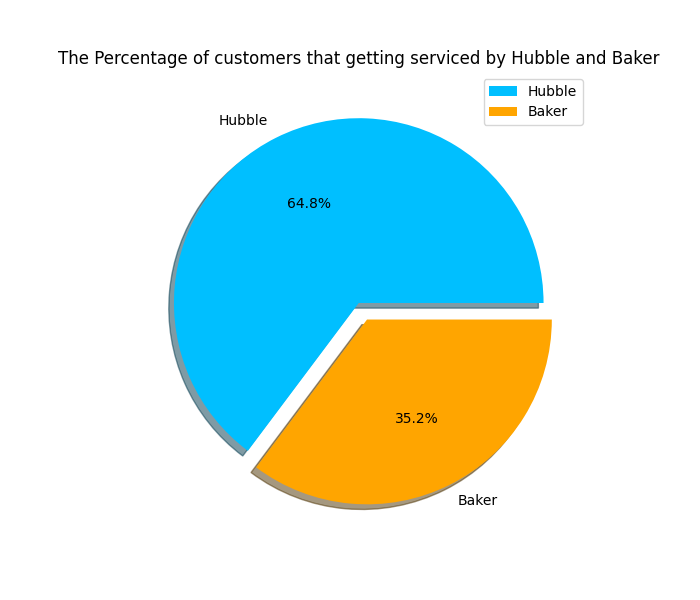

In [16]:
percent_hubble_customers = round((hubble_customers / total_customers) * 100, 2)
percent_baker_customers = round((baker_customers / total_customers) * 100, 2)

print(
    f"The {percent_hubble_customers:.2f}% are customers getting serviced by Hubble.\n"
    f"The {percent_baker_customers:.2f}% are customers getting serviced by Baker."
)

sizes = ( percent_hubble_customers, percent_baker_customers)
labels = ('Hubble', 'Baker')
colors = ('deepskyblue', 'orange')
explode = (0, 0.1)
fig, ax = plt.subplots(figsize = (7, 6))

ax.pie(sizes, explode = explode, colors = colors, labels = labels, autopct='%1.1f%%', shadow = True)
ax.set_title("The Percentage of customers that getting serviced by Hubble and Baker")
plt.legend()
plt.show()

# **Q6**:
### if a customer being wait in the queue for service more than 5 minutes, how much possible that person in not get back to get service by auto-restaurant ? calculate the possibility of this situation for 1, 2, 3, 5, 7, 10, 15, 18, 20, 22, 25, 30, 50 minutes and plot them on the diagram.

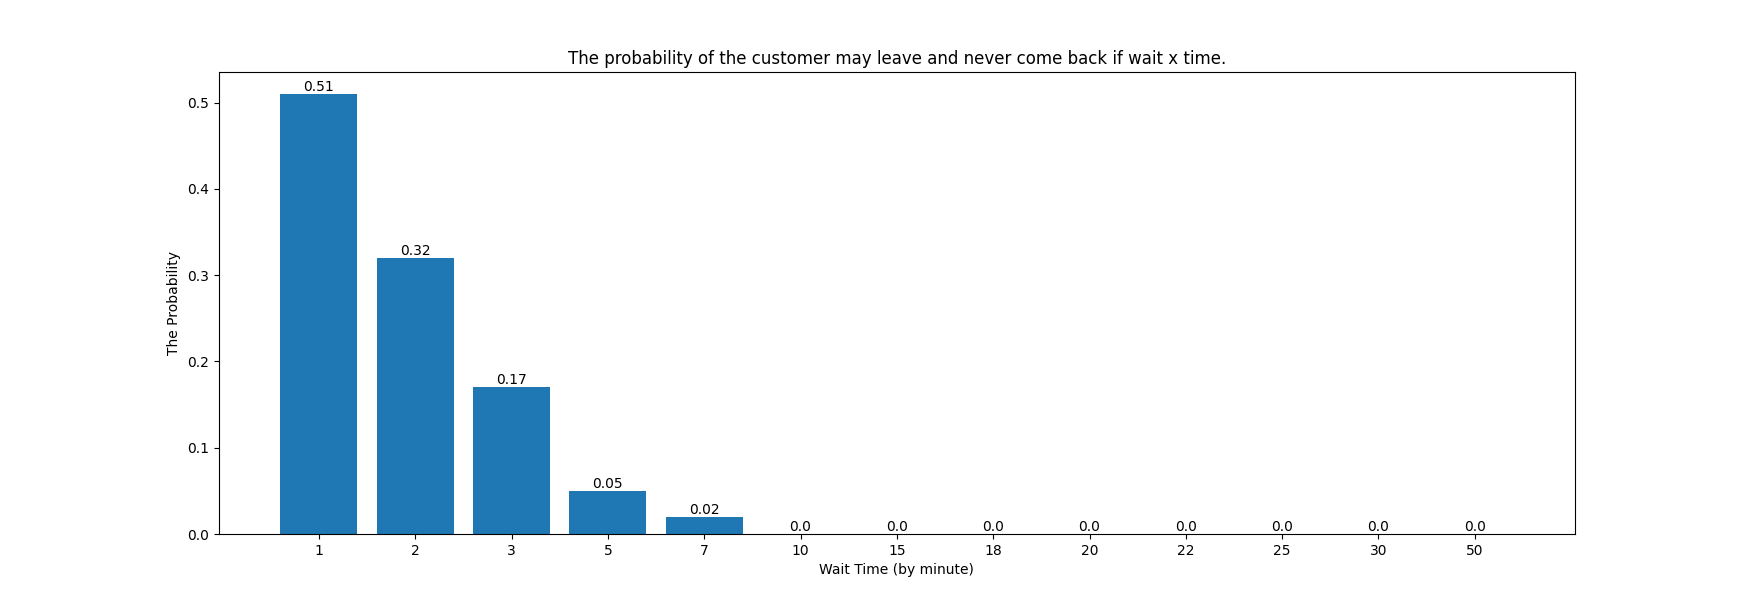

In [17]:
longer_times = (1, 2, 3, 5, 7, 10, 15, 18, 20, 22, 25, 30, 50)
names = ('1', '2', '3', '5', '7', '10', '15', '18', '20', '22', '25','30', '50')
values = []
for longer_time in longer_times:
    values.append(round((sum(1 for wait_time in wait_times if wait_time > longer_time ) / total_customers), 2))


plt.figure(figsize=(17.5, 6))
plt.title("The probability of the customer may leave and never come back if wait x time.")
plt.ylabel("The Probability")
plt.xlabel("Wait Time (by minute)")
plt.bar(names, values)

for i, values in enumerate(values):
    plt.text(i, values, str(values), ha='center', va='bottom')
plt.show()

# **Q7**:
## Just the average service time for Hubble and Baker in *Simulation* way.

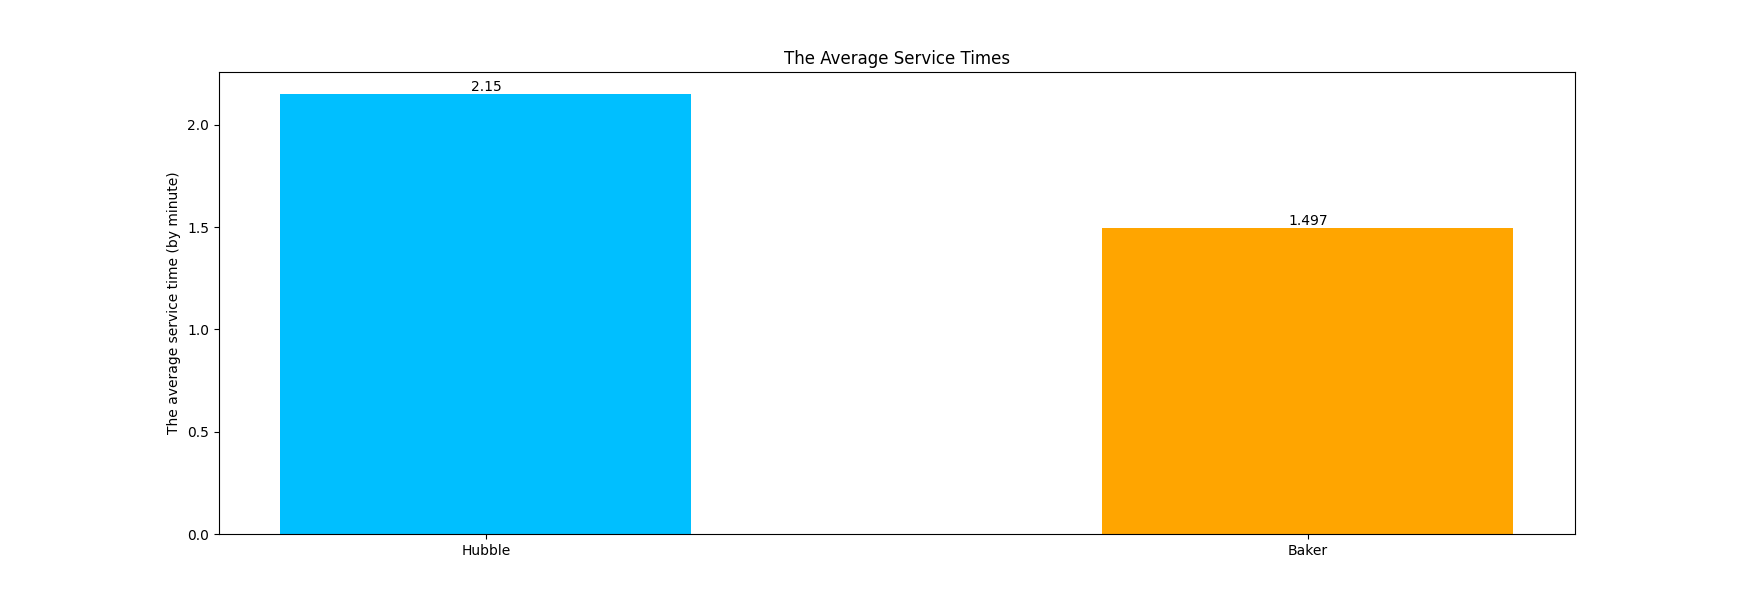

In [18]:
average_service_time_hubble = round(sum(hubble_service_times) / total_customers, 3)
average_service_time_baker = round(sum(baker_service_times) / total_customers, 3)


values = average_service_time_hubble, average_service_time_baker
names = ('Hubble', 'Baker')
colors = ('deepskyblue', 'Orange')


plt.figure(figsize=(17.5, 6))
plt.title("The Average Service Times")
plt.bar(names, values, color = colors, width = 0.5)

for i, values in enumerate(values):
    plt.text(i, values, str(values), ha='center', va='bottom')

plt.ylabel("The average service time (by minute)")
plt.show()


# **Q10**:
## If there are more than 5 customers getting wait in system , then the *congestion* occurred, determine how many congestions happen in this simulation.

In [19]:
print(f"The number of times that congestions occurred in the system :{len(getCongestionCounter())}")

The number of times that congestions occurred in the system :4


# **Q12**:
## plot the **B(t)** and **Q(t)**, *B(t)* means the busy indicator, which is a system shows that in the time of *t* the system is busy or not; and *Q(t)* means that there are how many people in the time of *t*.


# **B(t)**

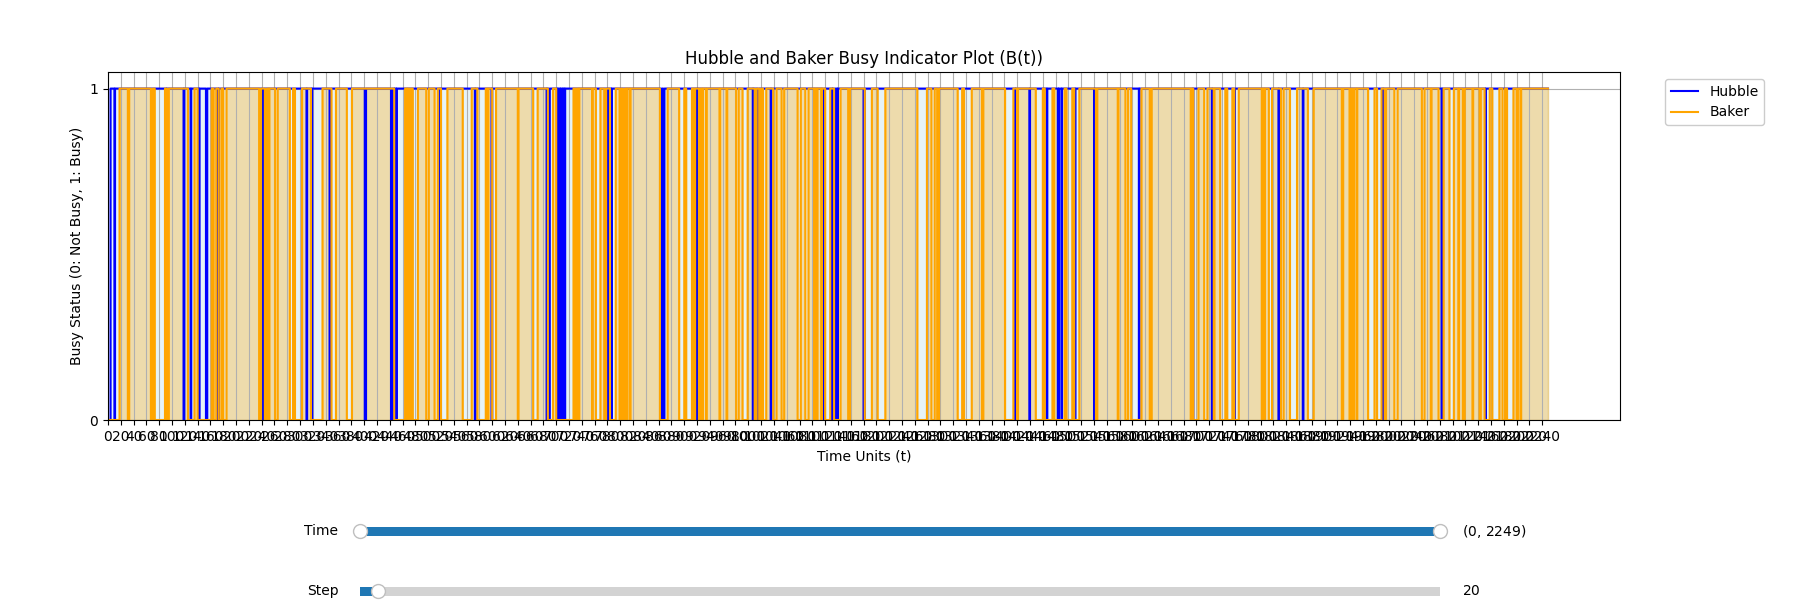

In [20]:
start_time = 0
end_time = TIME_UNIT - 1
step = 20

def calculateBusyIndicator(working_time):
    time_points = []
    busy_indicator_values = []
    
    for time_unit in range(start_time, end_time + 1):
        is_busy = any(start <= time_unit < end for start, end in working_time)
        busy_indicator_values.append(1 if is_busy else 0)
        time_points.append(time_unit) 
    
    return time_points, busy_indicator_values

from matplotlib.widgets import RangeSlider, Slider


hubble_busy_values = calculateBusyIndicator(hubble_working_time)
baker_busy_values = calculateBusyIndicator(baker_working_time)

fig, ax = plt.subplots(figsize = (18, 6))

plt.subplots_adjust(left = 0.06 ,bottom = 0.3)
ax.step(hubble_busy_values[0], hubble_busy_values[1], label = 'Hubble', where = 'post', color = 'blue')
ax.fill_between(hubble_busy_values[0], hubble_busy_values[1], step = 'post', color = 'lightblue', alpha = 0.3)

ax.step(baker_busy_values[0], baker_busy_values[1], label = 'Baker', where = 'post', color = 'orange')
ax.fill_between(baker_busy_values[0], baker_busy_values[1], step = 'post', color = 'orange', alpha = 0.3)

ax.set(xlabel = 'Time Units (t)', ylabel = 'Busy Status (0: Not Busy, 1: Busy)',
       title = 'Hubble and Baker Busy Indicator Plot (B(t))', xticks = range(start_time, end_time + 1, step),
       yticks = range(0, 2))
ax.set_ylim(ymin = 0)
ax.grid(True)


range_slider_ax = plt.axes((0.2, 0.1, 0.6, 0.03), facecolor='lightgoldenrodyellow')
range_slider = RangeSlider(range_slider_ax, 'Time', valmin = start_time, valmax = end_time, valinit = (start_time, end_time))

step_slider_ax = plt.axes((0.2, 0, 0.6, 0.03), facecolor='lightgoldenrodyellow')
step_slider = Slider(step_slider_ax, 'Step', valmin = 1, valmax = TIME_UNIT / 2, valinit = step)

def updateStepSlider(val):
    step = int(step_slider.val)
    ax.set_xticks(range(start_time, end_time + 1, step))
    fig.canvas.draw_idle()
    
def updateSlider(val):
    xmin, xmax = range_slider.val
    ax.set_xlim(xmin, xmax)
    fig.canvas.draw_idle()

range_slider.on_changed(updateSlider)
step_slider.on_changed(updateStepSlider)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.legend(loc = 'upper right', frameon = True, framealpha = 1.0, bbox_to_anchor=(1.1, 1))
plt.show()

In [21]:
for _ in range(2):
    total_server_count.pop()
print(len(total_server_count))    

516


# **Q(t)**

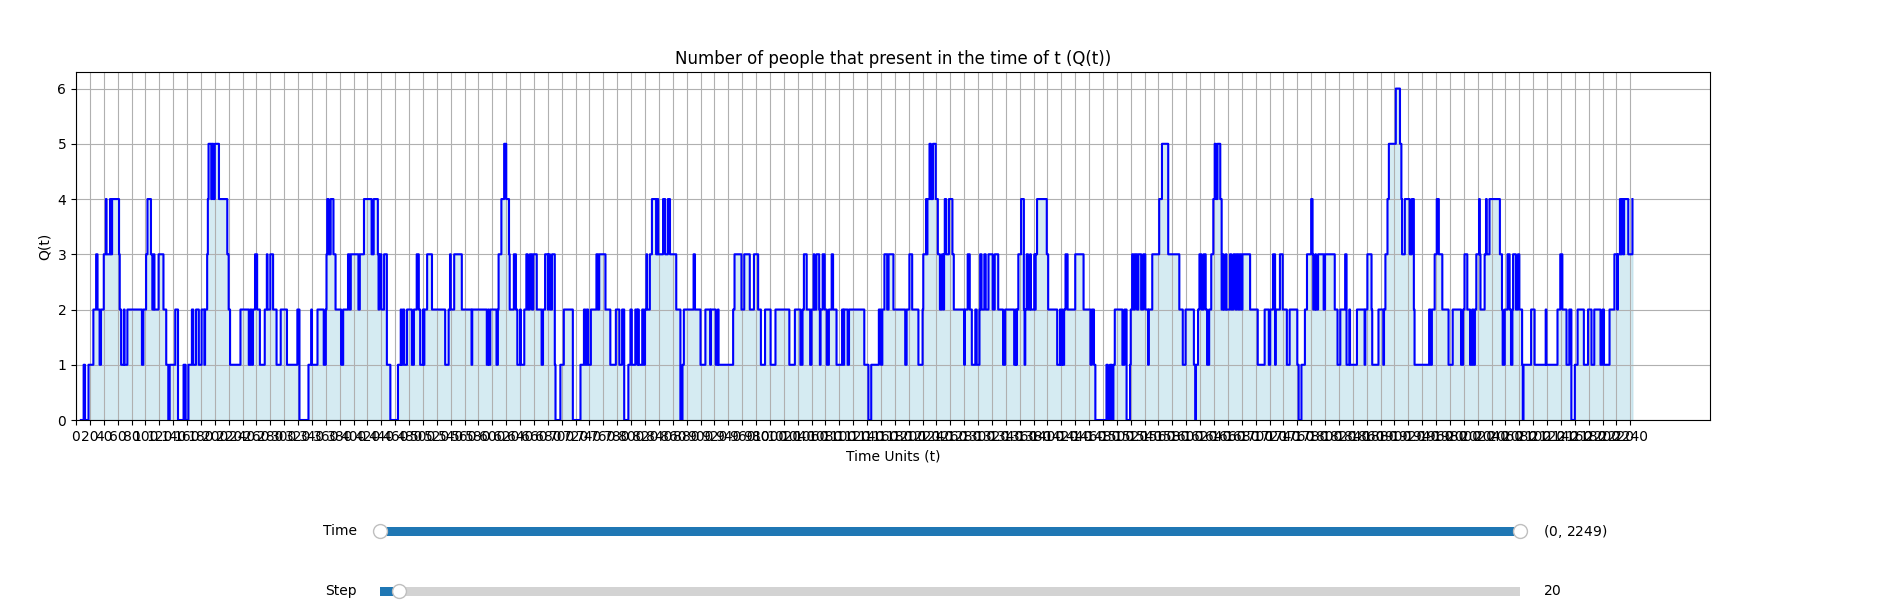

In [22]:

fig, ax = plt.subplots(figsize = (19, 6))

x_coords = [point[0] for point in server_time]

plt.subplots_adjust(left = 0.04 ,bottom = 0.3)
ax.plot(x_coords, total_server_count, drawstyle = 'steps-post', color = 'blue')
ax.fill_between(x_coords, total_server_count, step = 'post', color = 'lightblue', alpha = 0.5)

ax.set(xlabel = 'Time Units (t)', ylabel = 'Q(t)',
       title = 'Number of people that present in the time of t (Q(t))', xticks = range(start_time, end_time + 1, step))

ax.set_ylim(ymin = 0)
ax.grid(True)

range_slider_ax = plt.axes((0.2, 0.1, 0.6, 0.03), facecolor='lightgoldenrodyellow')
range_slider = RangeSlider(range_slider_ax, 'Time', valmin = start_time, valmax = end_time, valinit = (start_time, end_time))

step_slider_ax = plt.axes((0.2, 0, 0.6, 0.03), facecolor='lightgoldenrodyellow')
step_slider = Slider(step_slider_ax, 'Step', valmin = 1, valmax = TIME_UNIT / 2, valinit = step)

def updateStepSlider(val):
    step = int(step_slider.val)
    ax.set_xticks(range(start_time, end_time + 1, step))
    fig.canvas.draw_idle()
    
def updateSlider(val):
    xmin, xmax = range_slider.val
    ax.set_xlim(xmin, xmax)
    fig.canvas.draw_idle()

range_slider.on_changed(updateSlider)
step_slider.on_changed(updateStepSlider)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.show()